# MSO Dataset

In [ ]:
## MSO DATASET
import pyreadr
from pyreadr import pyreadr as pyr
import pandas as pd
import numpy as np

path = "D:/2018_case_dataset/data/mobile_data.rds"
data = pyr.read_r(path)
for key, val in data.items():
    df = val
def get_avail_data(i):
    final = str(i).split('-')[0][1:]
    return int(final)
df['Case Cover ID'] = df['Case Cover ID'].astype('str')
df = df.loc[(df['Case Cover ID'].apply(get_avail_data) >= 180101) & (df['Case Cover ID'].apply(get_avail_data) <= 190304)]

In [ ]:
import os
import numpy as np
filenames = []
for subdir, dirs, files in os.walk("d:/Preliminary_Image_Dataset"):
            for file in files:
                idxfile = file.split("_")[0]
                idxfile = idxfile.split(".")[0]
                idxfile = idxfile[:14]
                print("idxfile:",idxfile)
                filenames.append(idxfile)
                #if len(df.loc[df['Case Cover ID'] == idxfile].index) != 0:
                #   print(idxfile)
                  
filenames = np.unique(np.array(filenames))

## Indexing the data that have images with it

In [ ]:
filenamesarr = pd.DataFrame(filenames,columns=['name'])
df_cleaned = df[df['Case Cover ID'].isin(filenamesarr.name)]
df_cleaned

## Getting number of cases based on simple word tagging

In [ ]:
#df_cleaned[['First Receiving Agency Name', 'Case Owner Agency Name','New Case Type']]
import re
pd.set_option('display.max_colwidth', -1)
df_notincharge = df_cleaned.loc[df_cleaned['First Receiving Agency Name'] != df_cleaned['Case Owner Agency Name']]
def noun_encoding(text):
    newtext = re.sub('[^A-Za-z0-9]+', '', text)
    newtext = newtext.lower()
    if 'bicycle' in newtext:
        return 'bicycle'
    if ('bird' or 'pigeon') in newtext:
        return 'pigeons'
    if 'stair' in newtext:
        return 'stairwell'
    if ('trash' or 'bin' or 'litter') in newtext:
        return 'trashbin'
    if 'chute' in newtext:
        return 'chute'
    if ('lorry' or 'lorries' or 'car' or 'motor' or 'truck') in newtext:
        return 'vehicles'
    if ('trolly' or 'trolley') in newtext:
        return 'trolley'
    if ('road' or 'walk' or 'pavement') in newtext:
        return 'roads'
    if 'cars' in newtext:
        return 'cars'
    if 'lift' in newtext:
        return 'lift'
    

df_notincharge['img_cat'] = df_notincharge['clean_text'].apply(noun_encoding)
df_notincharge['img_cat']
df_notincharge['img_cat'].hist(figsize=(10,10))

# MSO Pytorch Image Dataset

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
class MSODataset(Dataset):
    def  __init__(self, img_path, label_path):
        self.samples = []
        self.transformations = transforms.Compose([transforms.ToTensor(),transforms.Resize(size=(32,32)), transforms.Normalize((125.3/255, 123.0/255, 113.9/255), (63.0/255, 62.1/255.0, 66.7/255.0))])
        data = pyr.read_r(label_path)
        for key, val in data.items():
            df = val
        i = 1      # Limit the number of samples due to hardware limitations
        
        for subdir, dirs, files in os.walk(img_path):
            for file in files:
                idxfile = file.split("_")[0]
                print("idxfile:",idxfile)
                print(len(df.loc[df['Case Cover ID'] == idxfile].index)) 
                if len(df.loc[df['Case Cover ID'] == idxfile].index) != 0:       #Check if image name has an entry in the table
                    print(os.path.join(subdir,file))
                    img = Image.open(os.path.join(subdir, file))

                    label = agencyencoding(df.loc[df["Case Cover ID"] == idxfile, "COA"].values[0])
                    print(label)
                    self.samples.append((img, label))
                    #img.close()
                    i += 1
                    print(i)
                if i == 8000:
                    return
                
            

    def __getitem__(self, index):
        img, label = self.samples[index]
        img = self.transformations(img)
        #plt.imshow(img.permute(1,2,0))
        #plt.show()
        return (img,label)
    def __len__(self):
        return len(self.samples)

imgpath = "D:/2018_Case_Image_Dataset/2018_Case_Image_Dataset"
labelpath = "D:/2018_case_dataset/data/mobile_data.rds"
gdata = MSODataset(imgpath, labelpath)

# Root finding for Gaussian KDE (threshold selection)

In [34]:
import numpy as np
import time
from scipy import misc
from scipy.stats import gaussian_kde
import pickle
import torch
import matplotlib.pyplot as plt
import seaborn as sns

diff = [0, 1]

def find_intersection(kde1, kde2, init_interval=0.00001, scope =[-9.8,-7], convergence=0.001):
        x_left = scope[0]
        x_right = scope[0]+init_interval
        while x_right < scope[1]:
            left = kde1(x_left)[0]-kde2(x_left)[0]
            right = kde1(x_right)[0]-kde2(x_right)[0]
            if left*right < 0: #meaning the functions intersected (an odd number of times) in the interval
                if init_interval <= convergence:
                    return x_right
                else: 
                    return find_intersection(kde1, kde2, init_interval/10, scope=[x_left, x_right])
            else: #no intersection or an even number of intersections in the interval
                x_left = x_right
                x_right+=init_interval
        return scope[0]-1 #out of scope means no intersection

def test(indata, outdata, plot=False):
    global diff
    #cifar = np.zeros(9000)
    #other = np.zeros(9000)
    #other = np.zeros(2821)
    #other = np.zeros(5312)
    #other = np.zeros(3861)
    #other = np.zeros(1861)
    #other = np.zeros(2361)
    other = np.zeros(10000)
    cifar = np.zeros(400)
    np.random.seed(3)
    p1 = np.random.permutation(10000)
    #p2 = np.random.permutation(5312) #3861 or 5312
    for fold in range(1,6):
        print(fold)
        #data = pickle.load(open(f"./results/{indata}_{outdata}_{fold}.p", "rb" ))
        data = pickle.load(open(f"./results/{indata}_{outdata}_{fold}.p", "rb"))
        
        cnt = 0
        print("len of datainpro:",len(data[f'in_pro']))
        for i in range(len(data[f'in_pro'])):
            #if i in p1[:1000]: continue
            in_probs = data[f'in_pro'][i]        #probability values of all 8 classes
            #out_probs = data[f'out_pro'][i]
            in_probs_ = in_probs[np.nonzero(in_probs)]
            in_e = - np.sum(np.log(in_probs_) * in_probs_)
            #out_probs_ = out_probs[np.nonzero(out_probs)]
            #out_e = - np.sum(np.log(out_probs_) * out_probs_)

            cifar[cnt] += (np.max(in_probs) - in_e)
            #other[cnt] += (np.max(out_probs) - out_e)

            cnt += 1

        #gerry

        cnt = 0
        for i in range(len(data[f'out_pro'])):
            #if i in p1[:1000]: continue
            out_probs = data[f'out_pro'][i]
            out_probs_ = out_probs[np.nonzero(out_probs)]
            out_e = - np.sum(np.log(out_probs_) * out_probs_)

            other[cnt] += (np.max(out_probs) - out_e)
            cnt += 1

        #

    diff = cifar.tolist() + other.tolist()
    diff = sorted(list(set(diff)))
    cifar, other = np.array(cifar), np.array(other)
    print (f"#All: {len(data[f'in_pro'])} #Cifar: {len(cifar)} #Other: {len(other)}")
    
    kde1 = gaussian_kde(cifar)
    kde2 = gaussian_kde(other)
    
    print(find_intersection(kde1, kde2,scope=[np.mean(other),np.mean(cifar)],convergence=0.000001))

In [35]:
test('pid','Imagenet')

1
len of datainpro: 400
2
len of datainpro: 400
3
len of datainpro: 400
4
len of datainpro: 400
5
len of datainpro: 400
#All: 400 #Cifar: 400 #Other: 10000
-9.772188852278777


# Ablation study: Number of layers

In [ ]:
# FPR@95TPR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("c:/users/test/desktop/layers.csv",header='infer')

datafpr = data.iloc[:,:3]
datafprlift = datafpr.loc[(datafpr['OOD test/distribution set'] == 'Lift')].to_numpy()
datafprimagenet = datafpr.loc[(datafpr['OOD test/distribution set'] == 'Imagenet')].to_numpy()
datafprlsun = datafpr.loc[(datafpr['OOD test/distribution set'] == 'LSUN')].to_numpy()
plt.plot(datafprlift[:,0], datafprlift[:,2], label='Lift')
plt.plot(datafprimagenet[:,0], datafprimagenet[:,2], label='Imagenet')
plt.plot(datafprlsun[:,0], datafprlsun[:,2],label='LSUN')
plt.xlabel('No. of Layers')
plt.ylabel('FPR@95TPR')
plt.title('FPR@95TPR against No. of Layers')
plt.legend()

#plt.savefig('./figures/fpr.png',dpi=200)

In [ ]:
# AUROC
dataauroc = data.iloc[:,[0,1,3]]
dataauroclift = dataauroc.loc[(dataauroc['OOD test/distribution set'] == 'Lift')].to_numpy()
dataaurocimagenet = dataauroc.loc[(dataauroc['OOD test/distribution set'] == 'Imagenet')].to_numpy()
dataauroclsun = dataauroc.loc[(dataauroc['OOD test/distribution set'] == 'LSUN')].to_numpy()
plt.plot(dataauroclift[:,0], dataauroclift[:,2], label='Lift')
plt.plot(dataaurocimagenet[:,0], dataaurocimagenet[:,2], label='Imagenet')
plt.plot(dataauroclsun[:,0], dataauroclsun[:,2],label='LSUN')
plt.xlabel('No. of Layers')
plt.ylabel('AUROC')
plt.title('AUROC against No. of Layers')
plt.legend()
#plt.savefig('./figures/auroc.png',dpi=200)

In [ ]:
# AUPR
dataaupr = data.iloc[:,[0,1,4]]
dataauprlift = dataaupr.loc[(dataaupr['OOD test/distribution set'] == 'Lift')].to_numpy()
dataauprimagenet = dataaupr.loc[(dataaupr['OOD test/distribution set'] == 'Imagenet')].to_numpy()
dataauprlsun = dataaupr.loc[(dataaupr['OOD test/distribution set'] == 'LSUN')].to_numpy()
plt.plot(dataauprlift[:,0], dataauprlift[:,2], label='Lift')
plt.plot(dataauprimagenet[:,0], dataauprimagenet[:,2], label='Imagenet')
plt.plot(dataauprlsun[:,0], dataauprlsun[:,2],label='LSUN')
plt.xlabel('No. of Layers')
plt.ylabel('AUPR')
plt.title('AUPR against No. of Layers')
plt.legend()
#plt.savefig('./figures/aupr.png',dpi=200)

# Temperature against Mean Difference

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("c:/users/test/desktop/trend.csv",header='infer')
data 
data.to_numpy().astype(int)
x = data.iloc[:,0].to_numpy()
y = data.iloc[:,1].to_numpy()

plt.title("Mean Difference against Temperature")
plt.xlabel("Log(Temperature)")
plt.ylabel("Log(Mean Difference)")
plt.plot(np.log(x),np.log(y))

#plt.savefig("./figures/meandifftemp.png",dpi=200)
plt.show()


# Number of ID classes

In [ ]:
# FPR@95TPR
data = pd.read_csv("c:/users/test/desktop/numid.csv",header='infer')
data

datafpr = data.iloc[:,:3]
datafprpid = datafpr.loc[(datafpr['OOD dataset'] == 'PID')].to_numpy()
datafprimagenet = datafpr.loc[(datafpr['OOD dataset'] == 'Imagenet')].to_numpy()
datafprlsun = datafpr.loc[(datafpr['OOD dataset'] == 'LSUN')].to_numpy()
plt.plot(datafprpid[:,0].astype(int), datafprpid[:,2], label='PID')
plt.plot(datafprimagenet[:,0].astype(int), datafprimagenet[:,2], label='Imagenet')
plt.plot(datafprlsun[:,0].astype(int), datafprlsun[:,2],label='LSUN')
plt.xlabel('No. of ID classes')
plt.ylabel('FPR@95TPR')
plt.title('FPR@95TPR against No. of ID classes')
plt.legend()
#plt.savefig('c:/users/test/desktop/numIDfpr.png',dpi=200)

In [ ]:
# AUROC
dataauroc = data.iloc[:,[0,1,3]]
dataaurocpid = dataauroc.loc[(dataauroc['OOD dataset'] == 'PID')].to_numpy()
dataaurocimagenet = dataauroc.loc[(dataauroc['OOD dataset'] == 'Imagenet')].to_numpy()
dataauroclsun = dataauroc.loc[(dataauroc['OOD dataset'] == 'LSUN')].to_numpy()
plt.plot(dataaurocpid[:,0].astype(int), dataaurocpid[:,2], label='PID')
plt.plot(dataaurocimagenet[:,0].astype(int), dataaurocimagenet[:,2], label='Imagenet')
plt.plot(dataauroclsun[:,0].astype(int), dataauroclsun[:,2],label='LSUN')
plt.xlabel('No. of ID classes')
plt.ylabel('AUROC')
plt.title('AUROC against No. of ID classes')
plt.legend()
#plt.savefig('c:/users/test/desktop/numIDauroc.png',dpi=200)

In [ ]:
# AUPR
dataaupr = data.iloc[:,[0,1,4]]
dataauprpid = dataaupr.loc[(dataaupr['OOD dataset'] == 'PID')].to_numpy()
dataauprimagenet = dataaupr.loc[(dataaupr['OOD dataset'] == 'Imagenet')].to_numpy()
dataauprlsun = dataaupr.loc[(dataaupr['OOD dataset'] == 'LSUN')].to_numpy()
plt.plot(dataauprpid[:,0].astype(int), dataauprpid[:,2], label='PID')
plt.plot(dataauprimagenet[:,0].astype(int), dataauprimagenet[:,2], label='Imagenet')
plt.plot(dataauprlsun[:,0].astype(int), dataauprlsun[:,2],label='LSUN')
plt.xlabel('No. of ID classes')
plt.ylabel('AUPR')
plt.title('AUPR against No. of ID classes')
plt.legend()
#plt.savefig('c:/users/test/desktop/numIDaupr.png',dpi=200)

# Stability of fold

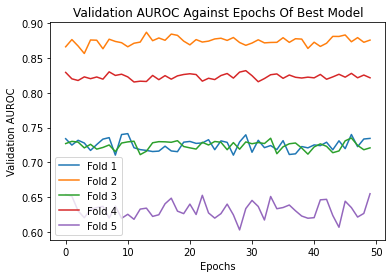

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
bestdata = pd.read_csv('figures/best_stability.csv')
x=0
for fold in range(1,6):
    x = bestdata.loc[bestdata['Fold'] == fold]
    xauroc = x.iloc[:,[0,2]].reset_index()
    plt.plot(xauroc['Valid AUROC'], label=f'Fold {fold}')
plt.title('Validation AUROC Against Epochs Of Best Model')
plt.xlabel('Epochs')
plt.ylabel('Validation AUROC')
plt.legend(loc=0)
plt.savefig('bestAurocStable.png',dpi=200)
plt.show()

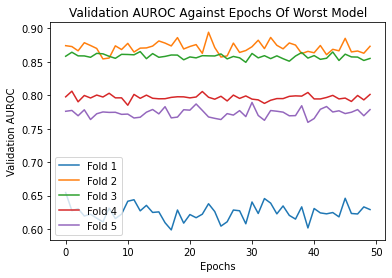

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
worstdata = pd.read_csv('figures/worst_stability.csv')
x=0
for fold in range(1,6):
    x = worstdata.loc[worstdata['Fold'] == fold]
    xauroc = x.iloc[:,[0,2]].reset_index()
    plt.plot(xauroc['Valid AUROC'], label=f'Fold {fold}')
plt.title('Validation AUROC Against Epochs Of Worst Model')
plt.xlabel('Epochs')
plt.ylabel('Validation AUROC')
plt.legend(loc=0)
plt.savefig('figures/worstAurocStable.png',dpi=200)
plt.show()

# External images Pytorch Dataset

In [16]:
import os
from PIL import Image
import numpy as np
root = './data/external-IN'
onlyfiles = [f for f in os.listdir(root)]
onlyfiles.remove("README.txt")
for i, classes in enumerate(onlyfiles):
    classes = os.path.join(root, classes)
    for j, images in enumerate(os.listdir(classes)):
        #img = np.array(Image.open(os.path.join(classes, images)))
        rgba_image = Image.open(os.path.join(classes, images))
        print(rgba_image)
    print(i, classes)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=560x420 at 0x26254D4D970>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=318x159 at 0x26254D69250>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=344x146 at 0x26254D69BB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2560x1706 at 0x26254D69250>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1200x878 at 0x26254D69670>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=680x453 at 0x26254D4DC40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=259x194 at 0x26254D4D970>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=225x225 at 0x26254D69670>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=275x183 at 0x26254D4D7C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2000x1333 at 0x26254D690A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1020x680 at 0x26254D4D970>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=289x174 at 0x26254D69250>
<PIL.JpegImagePlugin.J

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=827x443 at 0x26256253D60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=275x183 at 0x26254D69250>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=275x183 at 0x26254D690A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=283x178 at 0x26254D4DAC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x168 at 0x26254D690A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=290x174 at 0x26254D4DAC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1200x909 at 0x26254D69250>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=275x183 at 0x26254D4DAC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=181x278 at 0x26254D69250>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=168x300 at 0x26254D4DAC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=310x162 at 0x26254D690A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1201x630 at 0x26254D4DAC0>
<PIL.JpegImagePlugin.JpegI

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=528x370 at 0x26256267BB0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=249x263 at 0x26256253D60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=252x200 at 0x26256253F40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x1024 at 0x262561AA460>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=225x225 at 0x26256253BE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x335 at 0x26256253F40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=828x1000 at 0x26254D4DAC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=275x183 at 0x26256253D00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=225x225 at 0x262561AA460>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1600x1149 at 0x26256253D60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=528x960 at 0x26256253BE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=865x1390 at 0x26256253D00>
<PIL.JpegImagePlugin.Jpe

# Feature Exploration

## Extracting features from VGG16

In [2]:
import torchvision.models as models
import torchvision
from gdata import external, PreliminaryImageDataset
from utils.loader import PIDtrain, CIFAR10Mix
import torchvision.transforms as transforms
import sklearn
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset

vgg16 = models.vgg16(pretrained=True)
vgg16.classifier.add_module('7',nn.ReLU(inplace=True))
vgg16.classifier.add_module('8',nn.Dropout(p=0.5,inplace=False))
vgg16.classifier.add_module('9',nn.Linear(in_features = 1000, out_features = 50,bias=True))

In [3]:

#transform = transforms.Compose([
#    transforms.Resize((224,224)),
#    transforms.ToTensor(),
#    transforms.Normalize((125.3/255, 123.0/255, 113.9/255), (63.0/255, 62.1/255.0, 66.7/255.0)),
#])

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Indata = PreliminaryImageDataset(transform=transform)
testloaderIn = torch.utils.data.DataLoader(Indata, batch_size=32, shuffle=False, num_workers=2)
#Outdata = torchvision.datasets.ImageFolder(os.path.expanduser("./data/{}".format('Imagenet')), transform=transform)
#testloaderOut = torch.utils.data.DataLoader(Outdata, batch_size=32, shuffle=False, num_workers=2)

Outdata = torchvision.datasets.ImageFolder(os.path.expanduser("./data/{}".format('iSUN')), transform=transform)
testloaderOut = torch.utils.data.DataLoader(Outdata, batch_size=32, shuffle=False, num_workers=2)

dataAll = ConcatDataset([Indata,Outdata])
dataAllloader = torch.utils.data.DataLoader(dataAll)

0 ./Preliminary_Image_Dataset\Bicycle
1 ./Preliminary_Image_Dataset\Cars
2 ./Preliminary_Image_Dataset\Chute
3 ./Preliminary_Image_Dataset\Lift
4 ./Preliminary_Image_Dataset\Lorries
5 ./Preliminary_Image_Dataset\Motocycles
6 ./Preliminary_Image_Dataset\Pigeons
7 ./Preliminary_Image_Dataset\Road


KeyboardInterrupt: 

In [ ]:
vgg16.cuda()
vgg16.eval()
infeatures = np.zeros([1,50])
outfeatures = []
# For In-dist
for j, data in enumerate(dataAllloader):
    images, _ = data
    output = vgg16(images.cuda())
    cur_output = output.detach().cpu().numpy()
    infeatures = np.concatenate((infeatures,cur_output),0)


In [ ]:
features = np.array(infeatures).reshape(-1,50)
features = features[1:]      # Added an empty array at the beginning
labels = []
for i in range(len(dataAll)):
    if i < len(Indata):
        labels.append(Indata[i][1])
    else:
        labels.append(11)

### t-SNE plot

In [106]:
from sklearn.manifold import TSNE
labels2 = ['Bicycle','Cars','Chute','Lift','Lorries','Motocycles','Pigeons','Road','Stairwell','Trashbin','Trolley','iSUN']
colors_per_class = {'Bicycle': 'teal', 'Cars': 'blue', 'Chute': 'green', 'Lift':'brown', 
                    'Lorries':'orange', 'Motocycles':'pink','Pigeons':'purple','Road':'black',
                    'Stairwell':'cyan','Trashbin':'gray','Trolley':'olive' ,'iSUN':'red'}


tsne = TSNE(n_components=2).fit_transform(features)

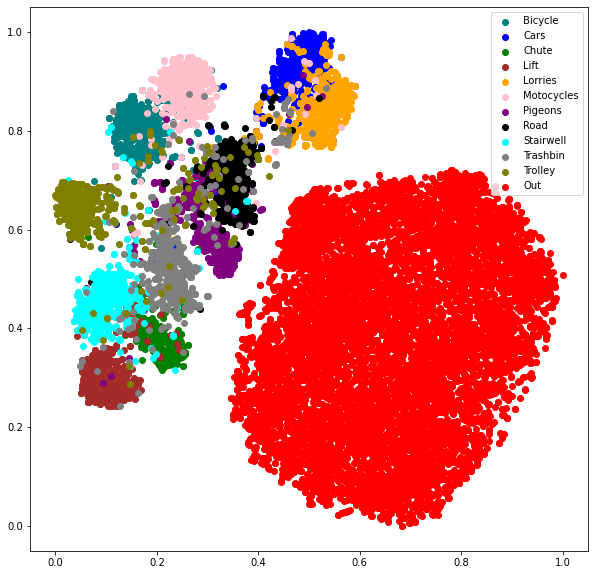

In [146]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
tx = tsne[:, 0]
ty = tsne[:, 1]
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

tx = scale_to_01_range(tx)
ty= scale_to_01_range(ty)

for j, label in enumerate(colors_per_class):
    indices = [i for i, l in enumerate(labels) if l == j]
    
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    color = colors_per_class[labels2[j]]
    ax.scatter(current_tx, current_ty, c=color, label=label)
ax.legend(loc='best')
plt.savefig('./figures/vgg16_tsne_2')
plt.show()           # If image changes, check variable 'labels'

# Using SVC to distinguish IN and OUT

In [ ]:
svmlabels = []
for i in range(len(dataAll)):
    if i < len(Indata):
        svmlabels.append(1)
    else:
        svmlabels.append(0)
# svmtraindata = np.vstack((tx,ty)).T

14237


In [ ]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(features,np.array(svmlabels))

In [ ]:
# Make externalin and externalout test sets, In = 0, Out = 1
#out_dataset = 'LSUN_resize'
externalout = external('./data/External-OUT',distribution='out',transform=transform)
#externalout = torchvision.datasets.ImageFolder(os.path.expanduser("./data/{}".format(out_dataset)), transform=transform)
externalloaderOut = torch.utils.data.DataLoader(externalout, batch_size=32, shuffle=False, num_workers=2)
externalin = external('./data/External-IN',distribution='in',transform=transform)
externalloaderIn = torch.utils.data.DataLoader(externalin, batch_size=32, shuffle=False, num_workers=2)

externalall = ConcatDataset([externalin,externalout])
externalallloader = torch.utils.data.DataLoader(externalall)

In [ ]:
vgg16.cuda()
vgg16.eval()
extfeatures = np.zeros([1,50])
# For In-dist
for j, data in enumerate(externalallloader):
    images, _ = data
    output = vgg16(images.cuda())
    cur_output = output.detach().cpu().numpy()
    extfeatures = np.concatenate((extfeatures,cur_output),0)

In [64]:
test_features = np.array(extfeatures).reshape(-1,50)
test_features = test_features[1:]      # Added an empty array at the beginning
labels = []
for i in range(len(externalall)):
    if i < len(externalin):
        labels.append(externalin[i][1])
    else:
        labels.append(11)

In [196]:
from sklearn.manifold import TSNE
labels2 = ['Bicycle','Cars','Chute','Lift','Lorries','Motocycles','Pigeons','Road','Stairwell','Trashbin','Trolley','Out']
colors_per_class = {'Bicycle': 'teal', 'Cars': 'blue', 'Chute': 'green', 'Lift':'brown', 
                    'Lorries':'orange', 'Motocycles':'pink','Pigeons':'purple','Road':'black',
                    'Stairwell':'cyan','Trashbin':'gray','Trolley':'olive' ,'Out':'red'}


tsne_test = TSNE(n_components=2).fit_transform(features)

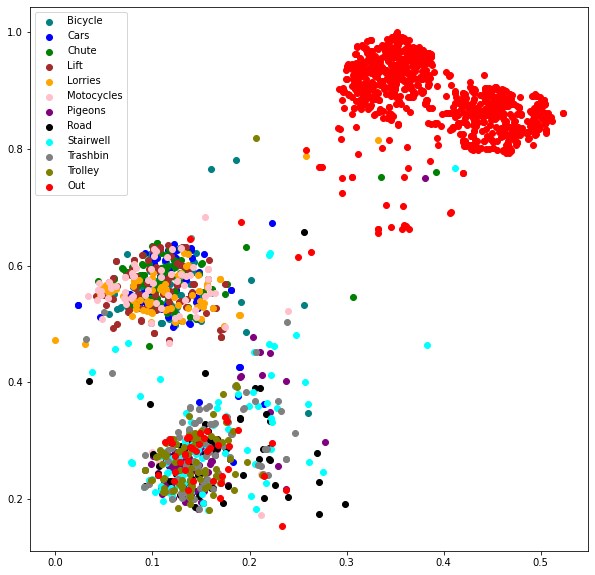

In [197]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
tx = tsne_test[:, 0]
ty = tsne_test[:, 1]
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

tx = scale_to_01_range(tx)
ty= scale_to_01_range(ty)

for j, label in enumerate(colors_per_class):
    indices = [i for i, l in enumerate(labels) if l == j]
    
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    color = colors_per_class[labels2[j]]
    ax.scatter(current_tx, current_ty, c=color, label=label)
ax.legend(loc='best')
plt.savefig('./figures/vgg16_tsne_test_externalout')
plt.show()

In [65]:
# Input into SVM
test_labels = []
for i in range(len(externalall)):
    if i < len(externalin):
        test_labels.append(1)
    else:
        test_labels.append(0)
#svmdata = np.vstack((tx,ty)).T

1864


In [66]:
# Metrics 
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve
print('auroc:',roc_auc_score(test_labels,clf.predict(test_features)))
print('precision:',precision_score(test_labels,clf.predict(test_features)))
print('recall:',recall_score(test_labels,clf.predict(test_features)))
fpr, tpr, thresholds = roc_curve(test_labels,clf.predict(test_features))
print('fpr:', fpr)

auroc: 0.5173697556477639
precision: 0.5260273972602739
recall: 0.995850622406639
fpr: [0.         0.96111111 1.        ]


ValueError: X.shape[1] = 2 should be equal to 50, the number of features at training time

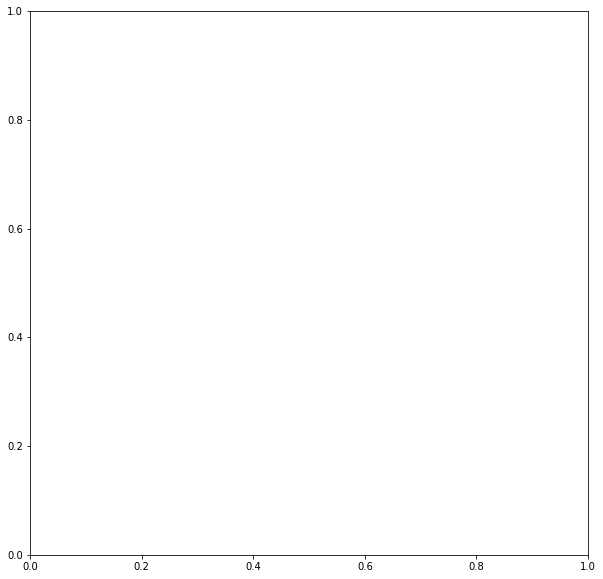

In [159]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
color = ['green','red']
name_labels = ['in','out']
for i in [0,1]:
    indices = [idx for idx,l in enumerate(clf.predict(svmdata)) if l==i]
    
    color = color[i]
    lbl = name_labels[i]
    ax.scatter(tsne_test[:,0][indices],tsne_test[:,1][indices],c=color,label=lbl)
ax.legend(loc='best')
plt.savefig('./figures/vgg16_tsne_svm_Imagenet_resize')

# Using K-nearest neighbours to distinguish IN and OUT

In [67]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
train_labels = []
for i in range(len(dataAll)):
    if i < len(Indata):
        train_labels.append(1)
    else:
        train_labels.append(0)
test_labels = []
for i in range(len(externalall)):
    if i < len(externalin):
        test_labels.append(1)
    else:
        test_labels.append(0)
    
neigh = KNeighborsClassifier(n_neighbors=5)
#neigh.fit(tsne, np.array(train_labels))
#preds = neigh.predict(tsne_test)
neigh.fit(features, np.array(train_labels))
preds = neigh.predict(test_features)
print('auroc:',roc_auc_score(test_labels,preds))
print('precision:',precision_score(test_labels,preds))
print('recall:',recall_score(test_labels,preds))
fpr, tpr, thresholds = roc_curve(test_labels,preds)
print('fpr:', fpr)

auroc: 0.5784416781927155
precision: 0.5604265402843602
recall: 0.9813278008298755
fpr: [0.         0.82444444 1.        ]


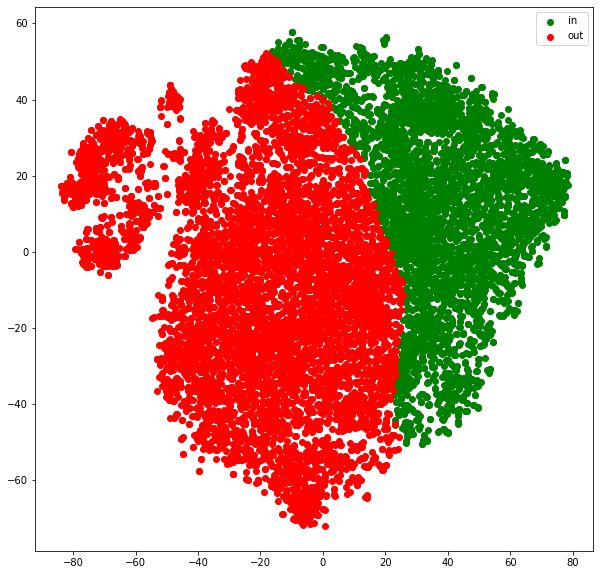

In [122]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
color = ['green','red']
name_labels = ['in','out']
for i in [0,1]:
    indices = [idx for idx,l in enumerate(preds) if l==i]
    
    color = color[i]
    lbl = name_labels[i]
    ax.scatter(tsne_test[:,0][indices],tsne_test[:,1][indices],c=color,label=lbl)
ax.legend(loc='best')
plt.savefig('./figures/vgg16_tsne_knn5_Imagenet')

# One-Class SVM

In [ ]:
from sklearn.svm import OneClassSVM
ocsvm = OneClassSVM(kernel='rbf')
ocsvm.fit(tsne)

In [ ]:
ocsvmpreds = ocsvm.predict(tsne_test)
ocsvmpreds = [0 if i == -1 else 1 for i in ocsvmpreds]
print('auroc:',roc_auc_score(test_labels,ocsvmpreds))
print('precision:',precision_score(test_labels,ocsvmpreds))
print('recall:',recall_score(test_labels,ocsvmpreds))
fpr, tpr, thresholds = roc_curve(test_labels,ocsvmpreds)
print('fpr:', fpr)

In [ ]:
ocsvmpreds = ocsvm.predict(tsne_test)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
color = ['green','red']
name_labels = ['in','out']
for i in [1,-1]:
    indices = [idx for idx,l in enumerate(ocsvmpreds) if l==i]
    if i == 1:
        color = 'green'
        lbl = 'in'
    else:
        color = 'red'
        lbl='out'
    ax.scatter(tsne_test[:,0][indices],tsne_test[:,1][indices],c=color,label=lbl)
ax.legend(loc='best')

# Comparison of simple classifiers and Ensemble against open-source

In [ ]:
out_datasets = ['Imagenet']#,'Imagenet_resize','LSUN','LSUN_resize']

for out_dataset in out_datasets:
    externalin = external('./data/External-IN',distribution='in',transform=transform)
    testsetout = torchvision.datasets.ImageFolder(os.path.expanduser("./data/{}".format(out_dataset)), transform=transform)
    externalall = ConcatDataset([externalin,externalout])
    externalallloader = torch.utils.data.DataLoader(externalall)
    
    vgg16.cuda()
    vgg16.eval()
    extfeatures = np.zeros([1,50])
    for j, data in enumerate(testloaderOut):
        images, _ = data
        output = vgg16(images.cuda())
        cur_output = output.detach().cpu().numpy()
        extfeatures = np.concatenate((extfeatures,cur_output),0)
    extfeatures = extfeatures[1:]
    tsne_test_opensource = TSNE(n_components=2).fit_transform(extfeatures)
    
    test_labels = []
    for i in range(len(externalall)):
        if i < len(externalin):
            test_labels.append(0)
        else:
            test_labels.append(1)
    
    preds = neigh.predict(tsne_test_opensource)
    print('auroc:',roc_auc_score(test_labels,preds))
    print('precision:',precision_score(test_labels,preds))
    print('recall:',recall_score(test_labels,preds))
    fpr, tpr, thresholds = roc_curve(test_labels,preds)
    print('fpr:', fpr)
    
    preds = clf.predict(tsne_test_opensource)
    print('auroc:',roc_auc_score(test_labels,preds))
    print('precision:',precision_score(test_labels,preds))
    print('recall:',recall_score(test_labels,preds))
    fpr, tpr, thresholds = roc_curve(test_labels,preds)
    print('fpr:', fpr)
    


# Saving CIFAR images

In [7]:
from PIL import Image
from torchvision import datasets
cifar10 = datasets.CIFAR100('data', train=True, download=True)
for i in range(10):
    img = cifar10[i][0]
    #img.save(f'c:/users/test/desktop/cifar100_{i}.jpg')

Files already downloaded and verified
